# Initial setup

In [42]:
import os
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import us
from addfips import AddFIPS
from matplotlib.colors import LinearSegmentedColormap

In [43]:
file_list = os.listdir("election")
dataframes = {}
for file_name in file_list:
    if file_name.endswith(".csv"):
        key_name = os.path.splitext(file_name)[0]
        file_path = os.path.join("election", file_name)
        df = pd.read_csv(file_path)
        dataframes[key_name] = df
pr = dataframes["primary_results"]
cfd = dataframes["county_facts_dictionary"]
cf = dataframes["county_facts"]
# Replace the column name with the description in the original DataFrame
for column_name in cf.columns:
    if column_name in cfd["column_name"].values:
        description = cfd.loc[cfd["column_name"] == column_name, "description"].iloc[0]
        cf.rename(columns={column_name: description}, inplace=True)
cf["area_name"] = cf["area_name"].str.replace("County", "").str.strip()
pr["county"] = pr["county"].str.replace("County", "").str.strip()
plt.style.use("dark_background")

# Introduction

We will analyse how people voted based on their geography, income and demography.

Please note, that these are primary election result from March. Actual election was done in November and even though populartiy vote was for Hillary aprox 48.2 % against Trump's 46.1%, Trump won the 2016 presidential election by securing a majority of electoral vote.

Electoral College System: The President of the United States is not elected by the popular vote but by the Electoral College. Each state is allocated a certain number of electoral votes based on its representation in Congress (senators + representatives). In most states, the candidate who wins the popular vote in that state receives all of its electoral votes. The candidate who reaches an absolute majority of 270 out of 538 electoral votes becomes the President.


We will use primary results as reference to candidate popularity. In a primary election, winners are determined within each political party separately. Primary elections are typically held to select the preferred candidate for each political party who will then represent the party in the general election.

The winners of a primary election are determined within each political party. The winning candidate from each party will then compete against candidates from other parties in the general election. The general election determines the ultimate winner who will hold the elected office, such as the presidency or a seat in the legislature.

In [5]:
sv = pd.pivot_table(pr, values="votes", index="state", columns="party", aggfunc="sum")
print("Total Democrat votes:", sv["Democrat"].sum())
print("Total Republican votes:", sv["Republican"].sum())

Total Democrat votes: 27660501.0
Total Republican votes: 29098686.0


# Dataset merging

## Fips Analysis

In [29]:
af = AddFIPS()
# Add FIPS codes to the DataFrame
for index, row in pr.iterrows():
    state_name = row["state"]
    county_name = row["county"]
    fips_code = af.get_county_fips(county_name, state=state_name)
    pr.loc[index, "fipsadd"] = fips_code
pr["fipsadd"] = pr["fipsadd"].astype(float)

In [30]:
pr["fips"] = pr["fips"].fillna(pr["fipsadd"])

In [19]:
prf = pd.pivot_table(
    pr,
    index=["fips", "state", "state_abbreviation", "county"],
    columns="candidate",
    values="votes",
    fill_value=0,
)
prf = prf.reset_index()
prf = prf.drop([" No Preference", " Uncommitted"], axis=1)

picking candidates with higher number of votes

In [21]:
prf = prf.drop(
    [
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "Marco Rubio",
    ],
    axis=1,
)

In [24]:
af = AddFIPS()
# Add FIPS codes to the DataFrame
for index, row in prf.iterrows():
    state_name = row["state"]
    county_name = row["county"]
    fips_code = af.get_county_fips(county_name, state=state_name)
    prf.loc[index, "fipsadd"] = fips_code
prf["fipsadd"] = prf["fipsadd"].astype(float)

comparing fipsadd and fips columns

In [25]:
u = prf["fipsadd"].isin(prf["fips"])
prf9 = prf[~u][prf[~u]["fips"] > 10000000]
print("fipsadd is not null - for fips above 90 m")
print(prf9[~prf9["fipsadd"].isnull()].shape[0])
print("fipsadd is null - for fips above 90 m")
print(prf9[prf9["fipsadd"].isnull()].shape[0])
prfn9 = prf[~u][prf[~u]["fips"] < 10000000]
print("fipsadd is not null - for fips bellow 90 m")
print(prfn9[~prfn9["fipsadd"].isnull()].shape[0])
print("fipsadd is null - for fips bellow 90 m")
print(prfn9[prfn9["fipsadd"].isnull()].shape[0])

fipsadd is not null - for fips above 90 m
39
fipsadd is null - for fips above 90 m
1369
fipsadd is not null - for fips bellow 90 m
2
fipsadd is null - for fips bellow 90 m
10


In [26]:
prf = prf.drop("fipsadd", axis=1)

In [27]:
u = prf["fips"].isin(cf["fips"])
prnf = prf[~u]

## Sample of mismatced data

In [28]:
prnf.head(2)

candidate,fips,state,state_abbreviation,county,Bernie Sanders,Donald Trump,Hillary Clinton,John Kasich,Ted Cruz
2798,90200101.0,Alaska,AK,State House District 1,9,134,3,12,151
2799,90200102.0,Alaska,AK,State House District 2,5,90,1,7,103


In [29]:
prnf[prnf["Bernie Sanders"] > 100000]

candidate,fips,state,state_abbreviation,county,Bernie Sanders,Donald Trump,Hillary Clinton,John Kasich,Ted Cruz
3007,91700103.0,Illinois,IL,Chicago,311225,32858,366954,21654,17737
3008,91700104.0,Illinois,IL,Cook Suburbs,212428,91520,249217,53481,50667


In [40]:
u4 = cf["fips"].isin(prf[prf["fips"] < 1000000]["fips"])
print(cf[~u4]["fips"].nunique())
u5 = prf[prf["fips"] > 10000000]["fips"].isin(cf["fips"])
print(prf[prf["fips"] > 10000000][~u5]["fips"].nunique())

387
1409


there are 1409 counties in primary that are not in county facts

Comparing states, all states that are primary results are in county facts

In [41]:
prf[~prf["state_abbreviation"].isin(cf["state_abbreviation"])]

candidate,fips,state,state_abbreviation,county,Bernie Sanders,Donald Trump,Hillary Clinton,John Kasich,Ted Cruz


primary results are missing DC and MN, however county facts cover all states, that are in primary results, so we can merge two datasets 

# 2016 primary election analysis on on state level 
(with primary ellection and county facts dataset)

## State vote and feature merging

In [22]:
sf = cf[cf["state_abbreviation"].isna()].drop(0)
sf = (
    sf.drop("state_abbreviation", axis=1)
    .rename(columns={"area_name": "state"})
    .set_index("state")
)

In [23]:
# Create a dictionary of DataFrames
states = {
    "psf": sf.iloc[:, 1:4],
    "asf": sf.iloc[:, 5:8],
    "ssf": sf.iloc[:, 8],
    "rsf": sf.iloc[:, 9:17],
    "livingInSameHouse": sf.iloc[:, 17],
    "foreignburn": sf.iloc[:, 18],
    "otherlanguageathome": sf.iloc[:, 19],
    "degreesf": sf.iloc[:, 20:23],
    "traveltowork": sf.iloc[:, 23],
    "hsf": sf.iloc[:, 24:30],
    "isf": sf.iloc[:, 30:33],
    "fsf": sf.iloc[:, 34:49],
    "lsf": sf.iloc[:, 50:52],
}

Creating public results per state

In [24]:
gs = pr.groupby(by=["state", "candidate"]).agg({"votes": "sum"})
prs = pd.pivot_table(
    gs, index="state", columns="candidate", values="votes", fill_value=0
)
prs = prs.drop(
    [
        " No Preference",
        " Uncommitted",
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "Marco Rubio",
    ],
    axis=1,
)

In [25]:
prstates = {}
for dataframe, df in states.items():
    updated_df = prs.merge(df, left_index=True, right_on="state")
    prstates[dataframe] = updated_df

In [26]:
for dfn in prstates:
    dfn = prstates[dfn]

## Population data and map function setup

In [37]:
psf = prstates["psf"]
psf.head(3)

,Bernie Sanders,Donald Trump,Hillary Clinton,John Kasich,Ted Cruz,"Population, 2014 estimate","Population, 2010 (April 1) estimates base","Population, percent change - April 1, 2010 to July 1, 2014"
state,,,,,,,,
Alabama,76399,371735,309928,37970,180608,4849377,4780127,1.4
Alaska,440,7346,99,892,7973,736732,710249,3.7
Arizona,163400,249916,235697,53040,132147,6731484,6392310,5.3


In [27]:
def get_state_name(state_code):
    try:
        state = us.states.lookup(state_code)
        if state is not None:
            return state.name
        else:
            return "Unknown"
    except Exception as e:
        print(f"Error occurred while looking up state name: {e}")
        return "Error"


# Read the shapefile containing county boundaries
shapefile_path = "election/county_shapefiles/cb_2014_us_county_5m.shp"
counties_df = gpd.read_file(shapefile_path)
# Aggregate counties to obtain state boundaries
states_df = counties_df.dissolve(by="STATEFP", aggfunc="first")
# Calculate centroids of each state
states_df["centroid"] = states_df["geometry"].apply(lambda geom: geom.centroid)
states_df["state"] = states_df.index.map(get_state_name)

In [41]:
def plot_map(dataframe, column_name):
    cmap = plt.cm.Reds
    norm = plt.Normalize(vmin=0, vmax=2000000)
    dataframe.plot(
        ax=ax,
        column=column_name,
        cmap=cmap,
        linewidth=0.8,
        edgecolor="black",
        norm=norm,
    )
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)


def plot_pr_map(df, column):
    # prepare datafarme and run ploting function
    states = states_df.join(df[column], on="state")
    plot_map(states, column)

## Voting on state level

In [45]:
psf.head(2)

,Bernie Sanders,Donald Trump,Hillary Clinton,John Kasich,Ted Cruz,"Population, 2014 estimate","Population, 2010 (April 1) estimates base","Population, percent change - April 1, 2010 to July 1, 2014"
state,,,,,,,,
Alabama,76399,371735,309928,37970,180608,4849377,4780127,1.4
Alaska,440,7346,99,892,7973,736732,710249,3.7


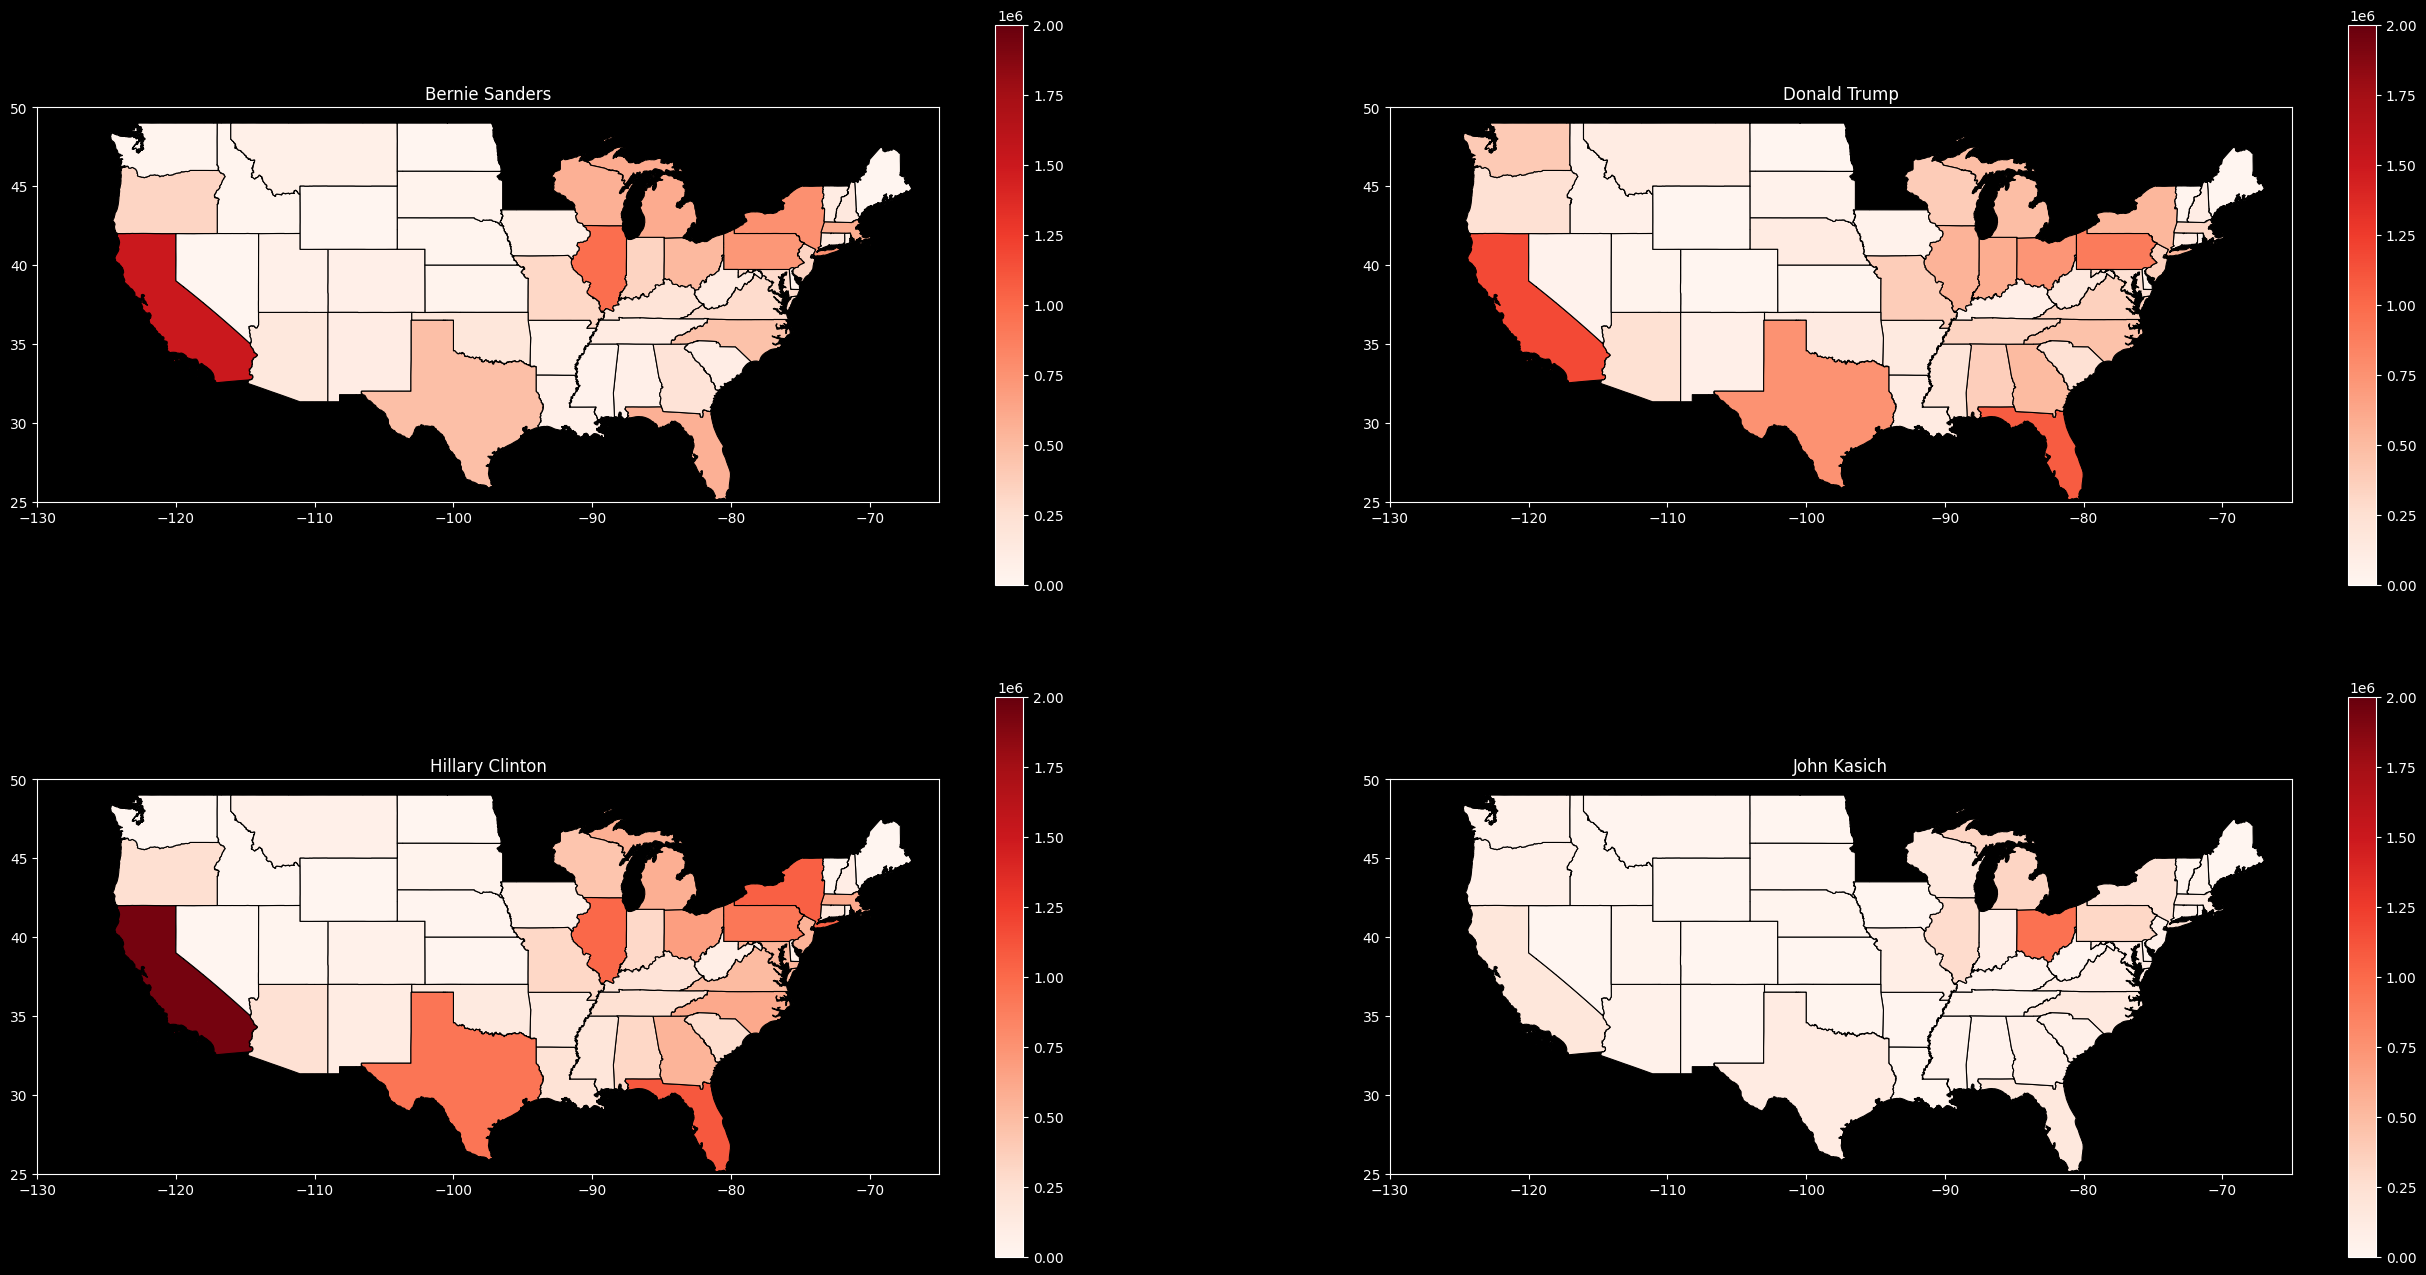

In [43]:
selected_columns = psf.iloc[:, :4]
num_plots = selected_columns.shape[1]
num_rows = num_plots // 2
num_cols = 2
fig, axs = plt.subplots(num_rows, num_cols, figsize=(32, 16))
for i, ax in enumerate(axs.flat):
    if i < num_plots:
        column_data = selected_columns.columns[i]
        plot_pr_map(psf, column=column_data)
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
        ax.set_title(column_data)

# County level EDA

## Create county data frames

In [29]:
pivot_table = pr.pivot_table(
    index=["fips", "state_abbreviation", "county"],
    columns="candidate",
    values="votes",
    aggfunc="sum",
    fill_value=0,
)
pivot_table = pivot_table.reset_index()
ccf = cf.rename(columns={"area_name": "county"})
df = pivot_table.merge(ccf, on="fips", how="outer").drop(
    [" No Preference", " Uncommitted"], axis=1
)
df = df.drop(
    [
        "Ben Carson",
        "Carly Fiorina",
        "Chris Christie",
        "Jeb Bush",
        """Martin O'Malley""",
        "Mike Huckabee",
        "Rand Paul",
        "Rick Santorum",
        "county_y",
        "state_abbreviation_y",
    ],
    axis=1,
)

gdf = df.dropna()
gdf = gdf.set_index("fips")
vfdf = gdf.iloc[:, 0:8]
pfdf = gdf.iloc[:, 9:13]
ifdf = gdf.iloc[:, 37:40]
afdf = gdf.iloc[:, 14:17]
rfdf = gdf.iloc[:, 16:23]


def cdf(df2):
    # creating dataframe with votes and one of county facts categories
    return vfdf.merge(df2, left_index=True, right_index=True)

## Correlation (positive/negative)

In [48]:
c = gdf.iloc[:, 2:].corr().iloc[6:, :3]
print(c.iloc[:, [0, 1]][(c.iloc[:, 0] - c.iloc[:, 1]).abs() > 0.1])
print(c.iloc[:, [0, 2]][(c.iloc[:, 2] - c.iloc[:, 0]).abs() > 0.08])
print(c.iloc[:, [2, 1]][(c.iloc[:, 1] - c.iloc[:, 2]).abs() > 0.11])

                                  Bernie Sanders  Donald Trump
Veterans, 2009-2013                     0.793217      0.901763
Population per square mile, 2010        0.365333      0.158970
                                                Bernie Sanders   
Black or African American alone, percent, 2014        0.060230  \
Black-owned firms, percent, 2007                      0.153633   

                                                Hillary Clinton  
Black or African American alone, percent, 2014         0.140498  
Black-owned firms, percent, 2007                       0.241758  
                                                    Hillary Clinton   
White alone, percent, 2014                                -0.202048  \
White alone, not Hispanic or Latino, percent, 2014        -0.253967   
Homeownership rate, 2009-2013                             -0.307827   
Persons below poverty level, percent, 2009-2013           -0.048342   
Nonemployer establishments, 2013                           

## Population setup

In [30]:
# Creating dataframe for population and votes
df = cdf(pfdf)

In [31]:
candidates = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
    "John Kasich",
    "Marco Rubio",
    "Ted Cruz",
]
shapefile_path = "election/county_shapefiles/cb_2014_us_county_5m.shp"
data = gpd.read_file(shapefile_path)
mdf = counties_df.merge(df, left_on="NAME", right_on="county_x")

### votes that are not in merged df

In [234]:
# df[df['county_y'].isnull()]['state_abbreviation_x'].unique()

array(['AK', 'CT', 'IL', 'KS', 'ME', 'MA', 'ND', 'RI', 'VT', 'WY'],
      dtype=object)

In [342]:
gv = df.iloc[:, 3:9]
gv.sum()

Bernie Sanders     11807518.0
Donald Trump       13202135.0
Hillary Clinton    15597200.0
John Kasich         4115040.0
Marco Rubio         3291044.0
Ted Cruz            7569817.0
dtype: float64

In [355]:
mv = df[df["county_y"].isnull()].iloc[:, 3:9]
mv.sum()

Bernie Sanders     1474706.0
Donald Trump        642563.0
Hillary Clinton    1474865.0
John Kasich         291558.0
Marco Rubio         171762.0
Ted Cruz            209992.0
dtype: float64

currently miaaing % of votes in county facts

In [354]:
mv.sum(axis=1).sum() / gv.sum(axis=1).sum() * 100

7.6740458020485995

In [356]:
mv.sum() / gv.sum() * 100

Bernie Sanders     12.489551
Donald Trump        4.867114
Hillary Clinton     9.455960
John Kasich         7.085180
Marco Rubio         5.219073
Ted Cruz            2.774070
dtype: float64

In [32]:
# Calculate the Population, 2014 column
df["Population, 2010 (April 1) estimates base"] = pd.to_numeric(
    df["Population, 2010 (April 1) estimates base"], errors="coerce"
)
df["Population, percent change - April 1, 2010 to July 1, 2014"] = pd.to_numeric(
    df["Population, percent change - April 1, 2010 to July 1, 2014"], errors="coerce"
)
df["Population, 2014"] = df["Population, 2010 (April 1) estimates base"] * (
    1 + df["Population, percent change - April 1, 2010 to July 1, 2014"] / 100
)
mdf = counties_df.merge(df, left_on="NAME", right_on="county_x")
mdf["Population, 2014 (log)"] = np.log10(mdf["Population, 2014"])

## Populatin in log scale

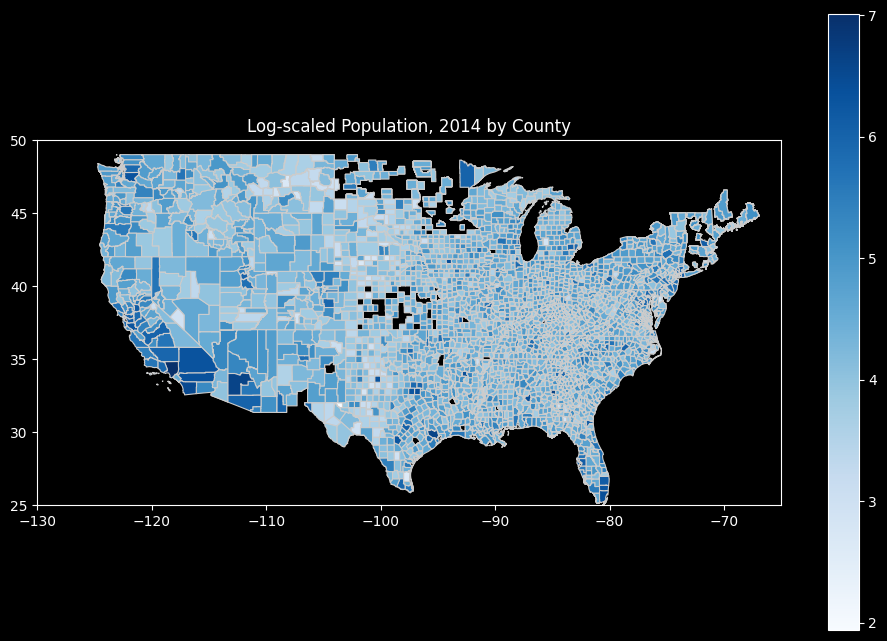

In [35]:
fig, ax = plt.subplots(figsize=(12, 8))
mdf.plot(
    column="Population, 2014 (log)",
    cmap="Blues",
    linewidth=0.8,
    ax=ax,
    edgecolor="0.8",
    legend=True,
)
ax.set_title("Log-scaled Population, 2014 by County")
ax.set_xlim(-130, -65)
ax.set_ylim(25, 50)
plt.show()

## Candidate votes

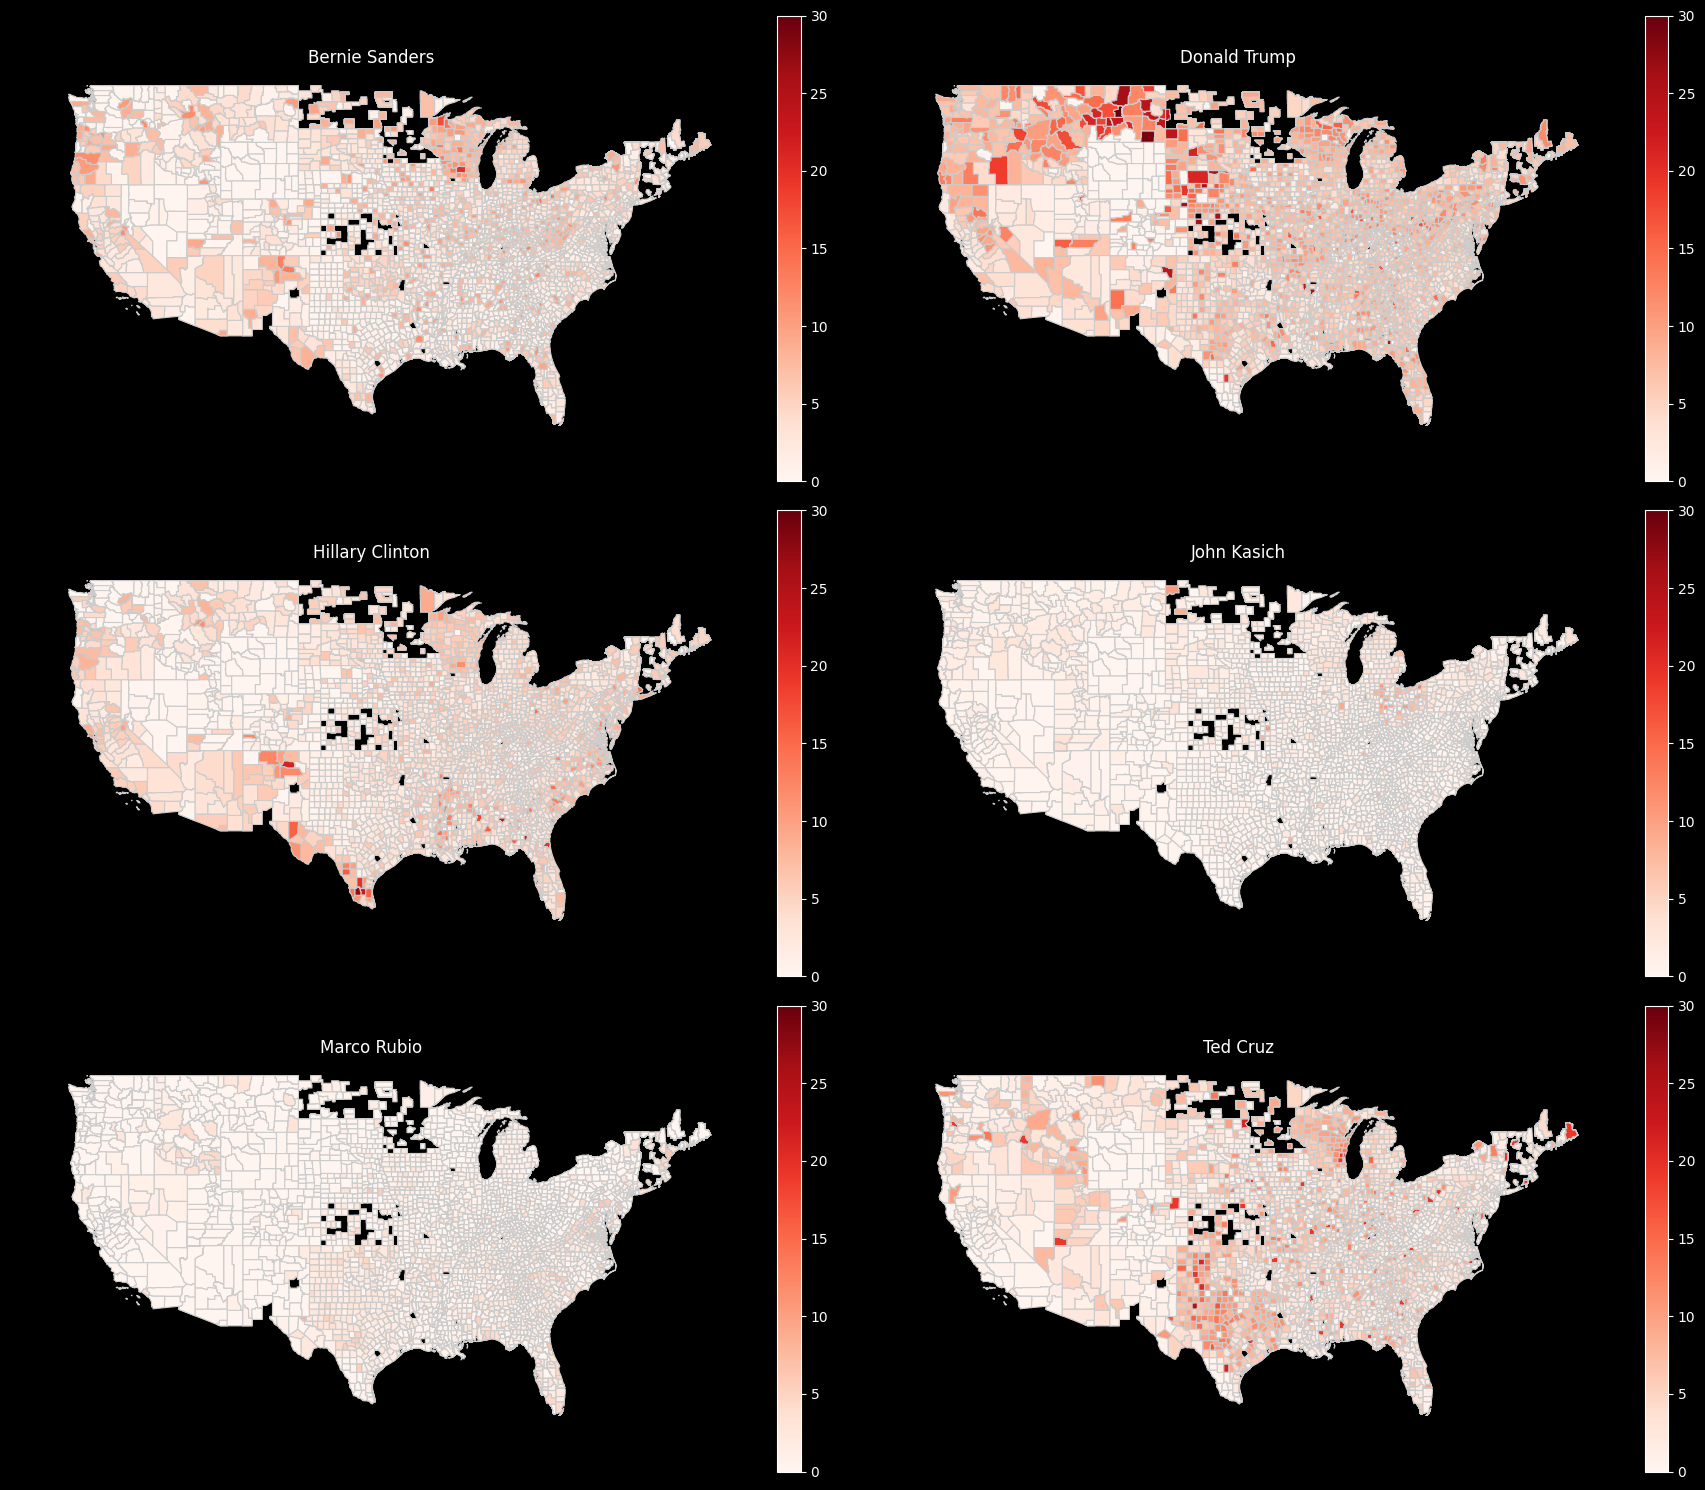

In [59]:
fig, axs = plt.subplots(
    len(candidates) // 2, 2, figsize=(18, 5 * (len(candidates) // 2))
)
cmap = plt.cm.Reds
norm = plt.Normalize(vmin=0, vmax=30)
# Plot maps for each candidate
for i, candidate in enumerate(candidates):
    ax = axs[i // 2, i % 2]
    mdf[candidate + "_percent"] = (mdf[candidate] / mdf["Population, 2014"]) * 100
    mdf.plot(
        ax=ax,
        column=candidate + "_percent",
        cmap=cmap,
        linewidth=0.8,
        edgecolor="0.8",
        legend=True,
        norm=norm,
    )
    ax.set_title(candidate)
    ax.set_axis_off()
    ax.set_xlim(-130, -65)
    ax.set_ylim(25, 50)
plt.tight_layout()
plt.show()

We see interesting result, eventhough by number of votes Clinton won primaries, but if we calculate vote precentage per all population we see that Trump mean is quite higher. Conclusion here is that in counties that were for Clinton, more people did not vote in primary elections.

In [61]:
mdf.iloc[:, -8:].mean()

Population, 2014           89302.515180
Population, 2014 (log)         4.501415
Bernie Sanders_percent         3.050330
Donald Trump_percent           6.400746
Hillary Clinton_percent        3.963114
John Kasich_percent            1.305500
Marco Rubio_percent            1.162841
Ted Cruz_percent               3.920997
dtype: float64

## Income

### Income Setup

In [68]:
df = cdf(ifdf)

update columns
use heads

In [70]:
bin_edges = range(
    0,
    int(df["Per capita money income in past 12 months (2013 dollars), 2009-2013"].max())
    + 10000,
    10000,
)
candidate_cols = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
    "John Kasich",
    "Marco Rubio",
]
total_votes = df[candidate_cols].sum()
percent_votes = (df[candidate_cols] / total_votes) * 100

pie_data = []
for i in range(len(bin_edges) - 1):
    votes_in_bin = df[
        (df.iloc[:, 8] >= bin_edges[i]) & (df.iloc[:, 8] < bin_edges[i + 1])
    ]
    pie_values = percent_votes.loc[votes_in_bin.index].mean()
    pie_data.append(pie_values)
    vote_count = votes_in_bin[candidate_cols].sum().sum()
    pie_data.append(vote_count)

### Candidates per income

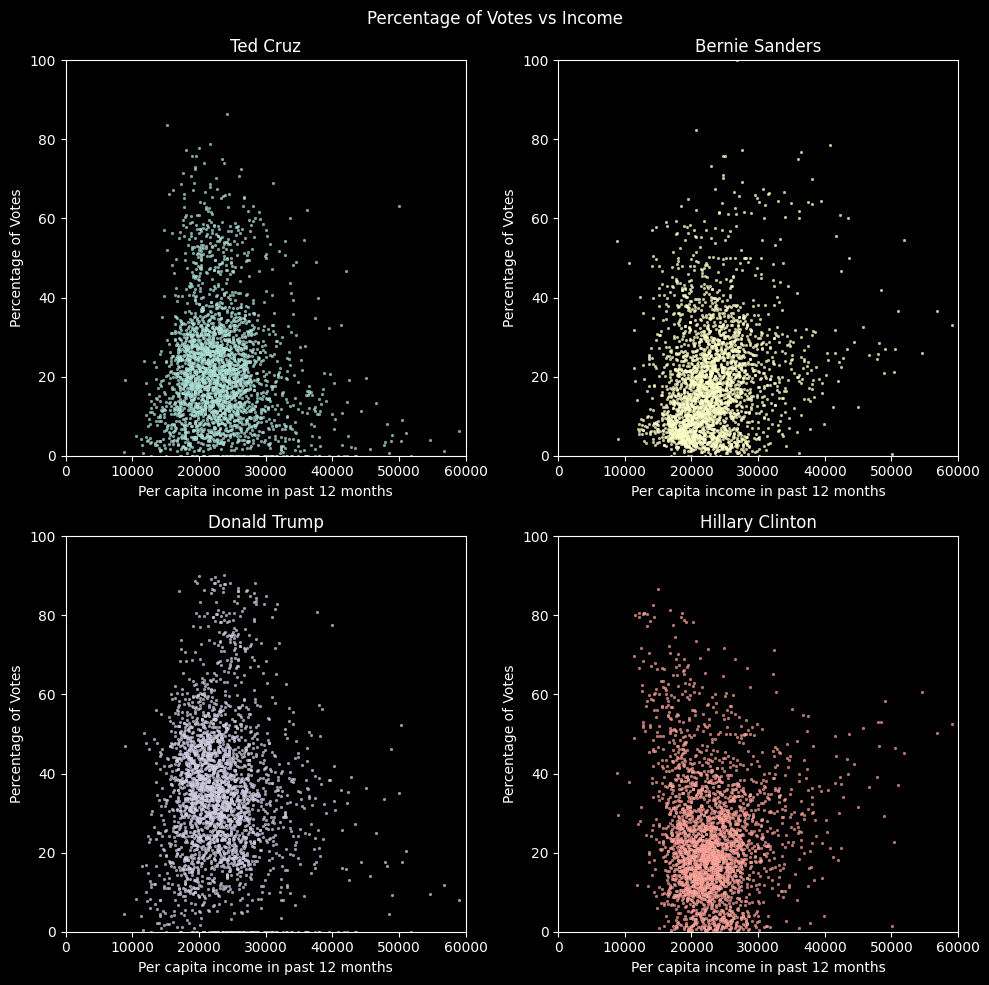

In [73]:
x = df["Per capita money income in past 12 months (2013 dollars), 2009-2013"]
candidate_cols = ["Ted Cruz", "Bernie Sanders", "Donald Trump", "Hillary Clinton"]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, candidate in enumerate(candidate_cols):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    y = (
        df[candidate] / df[candidate_cols].sum(axis=1) * 100
    )  # Calculate percentage of votes
    sns.scatterplot(x=x, y=y, color=f"C{i}", alpha=0.8, ax=ax, s=4)

    ax.set_xlabel("Per capita income in past 12 months")
    ax.set_ylabel("Percentage of Votes")
    ax.set_title(candidate)
    ax.set_xlim(0, 60000)
    ax.set_ylim(0, 100)
plt.suptitle("Percentage of Votes vs Income")
plt.tight_layout()
plt.show()

We see that Donald Trump gets more precents in main population, range between 15000 and 30000.  Hillary gets abit more in Range 40000 to 50000, however we see that there are much less counties in this range.

## Race

In [62]:
df = cdf(rfdf)

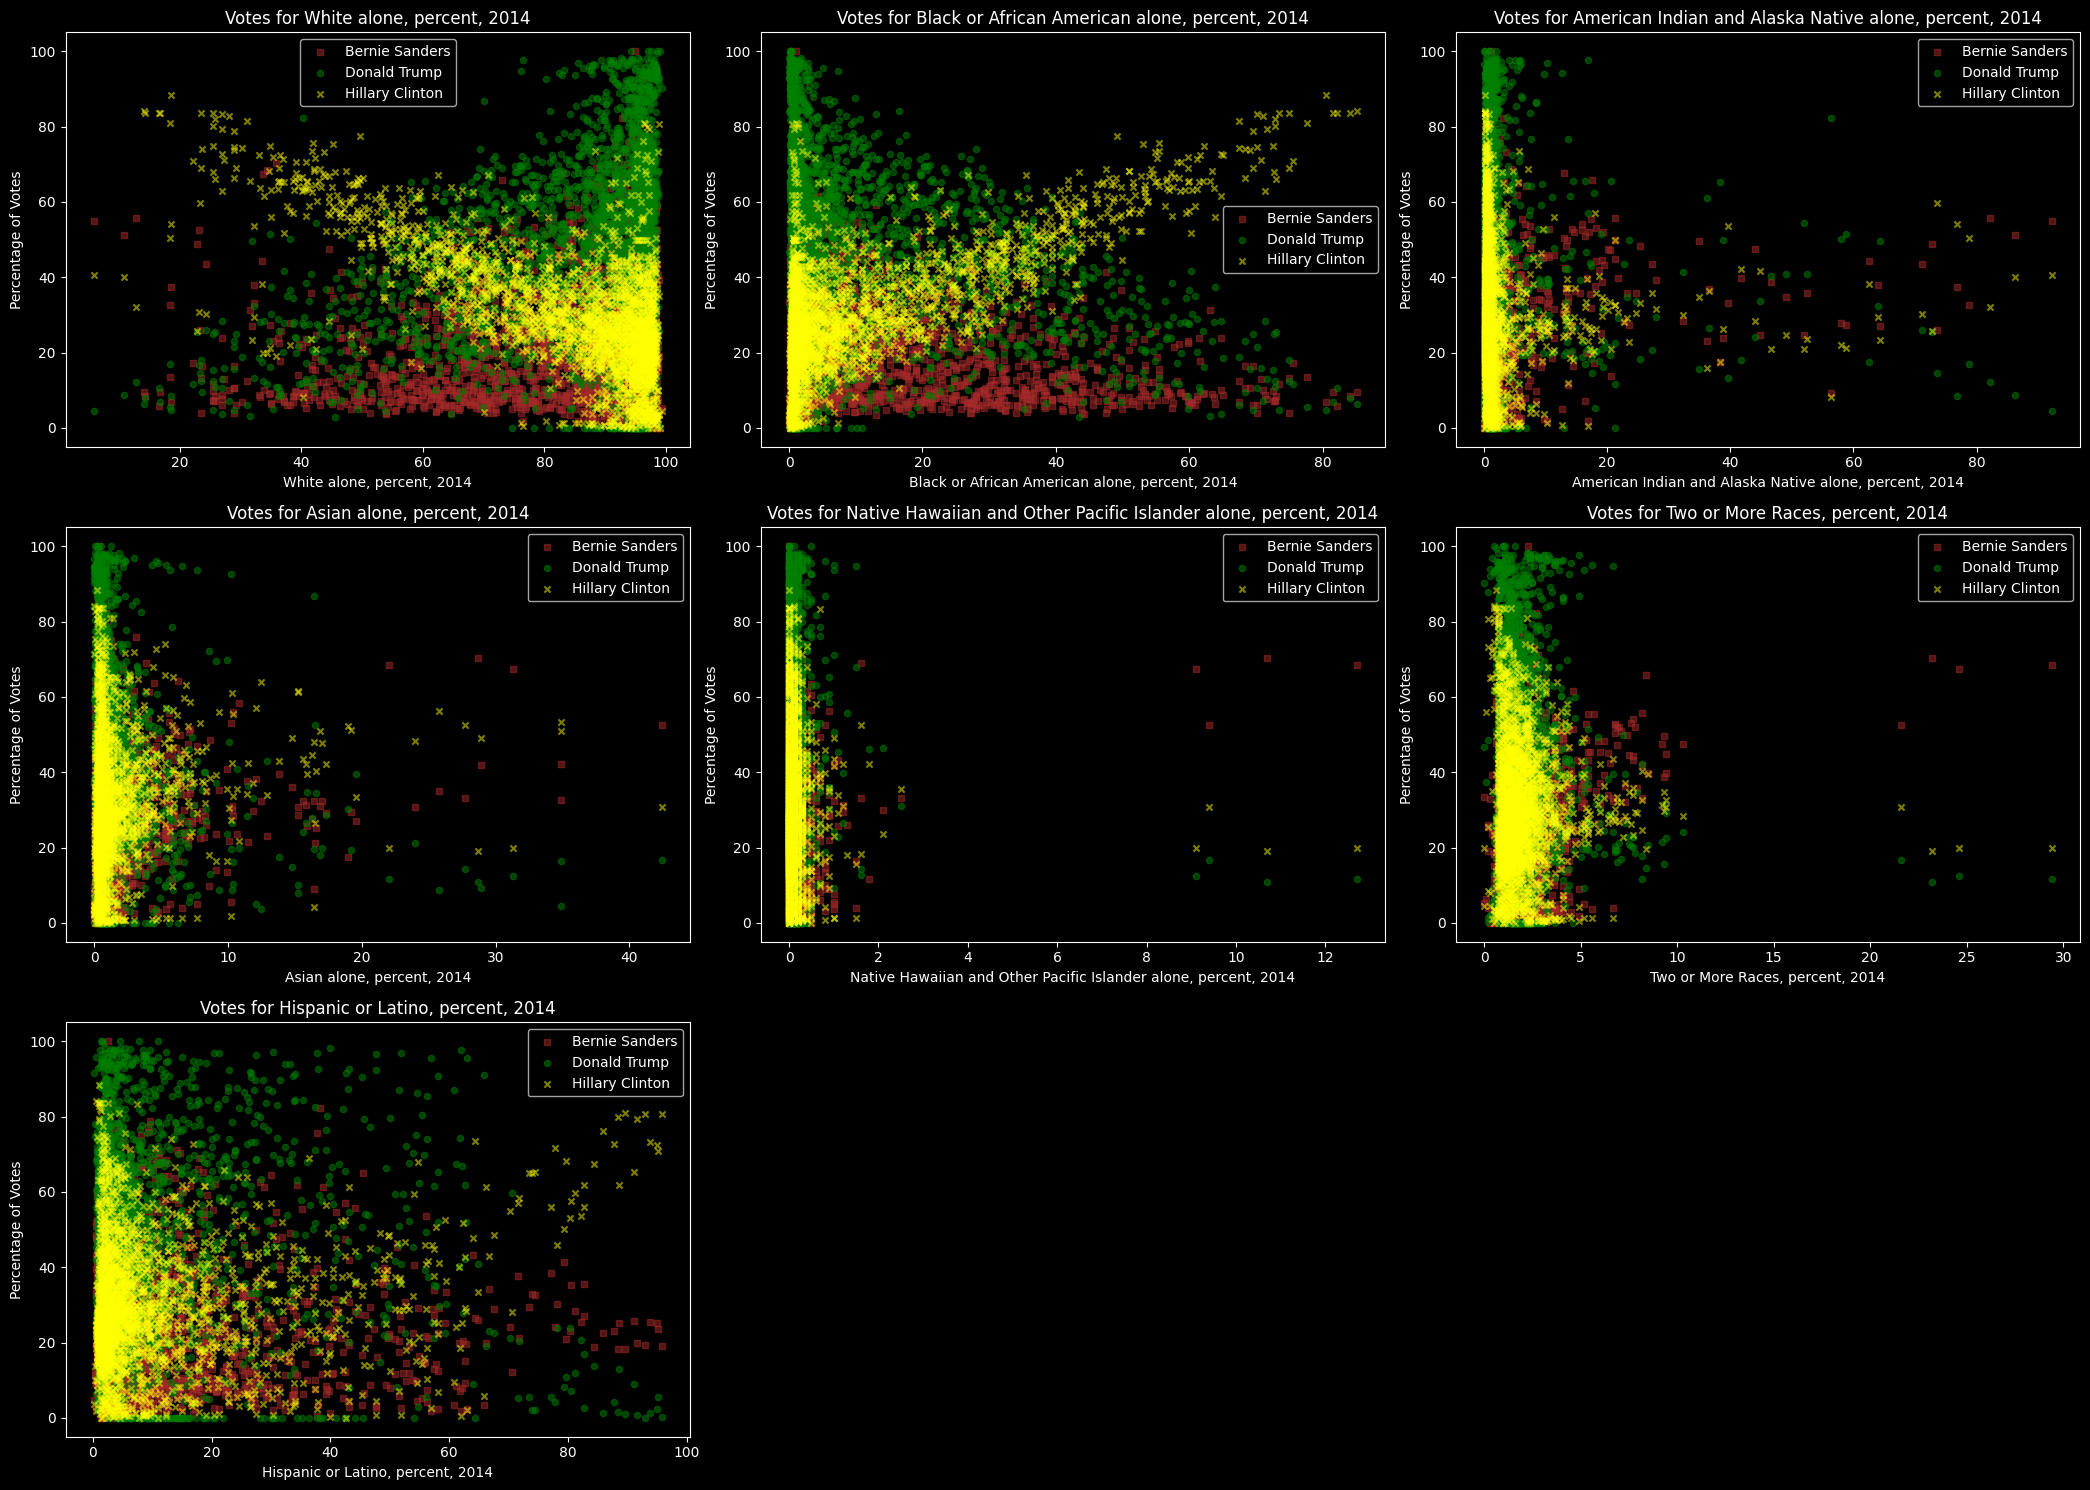

In [65]:
candidate_columns = [
    "Bernie Sanders",
    "Donald Trump",
    "Hillary Clinton",
]
df["Total Votes"] = df[candidate_columns].sum(axis=1)

colors = ["brown", "green", "yellow"]
markers = ["s", "o", "x", "v", "D", "^"]

plt.figure(figsize=(21, 15))

for i, demographic in enumerate(
    [
        "White alone, percent, 2014",
        "Black or African American alone, percent, 2014",
        "American Indian and Alaska Native alone, percent, 2014",
        "Asian alone, percent, 2014",
        "Native Hawaiian and Other Pacific Islander alone, percent, 2014",
        "Two or More Races, percent, 2014",
        "Hispanic or Latino, percent, 2014",
    ]
):
    plt.subplot(3, 3, i + 1)

    # Iterate through candidate columns
    for j, candidate in enumerate(candidate_columns):
        percentage_votes = (df[candidate] / df["Total Votes"]) * 100

        plt.scatter(
            df[demographic],
            percentage_votes,
            color=colors[j % len(colors)],
            alpha=0.5,
            label=candidate,
            marker=markers[j % len(markers)],
            s=20,
        )
    plt.xlabel(demographic)
    plt.ylabel("Percentage of Votes")
    plt.title(f"Votes for {demographic}")
    plt.legend()

plt.tight_layout()
plt.show()

Its clearly visible that white population votes for Trump, Black and Latino for Clinton, all other lean for Sanders.